# Onderzoek vragen

Wij hebben de volgende onderzoek vragen bedacht.

1. In hoeverre is de score van een Portugese Red te voorspellen op basis van de chemische kenmerken?
2. (Bonus) Kan men op basis van eigenschappen van eerder gereviewde wijnen voorspellen wat een recensent van een wijn zal vinden.
3. Welk effect heeft weer over de jaren heen effect op de wijn score die reviewers geven in punten?
4. Kan je op basis van score en prijs welke regio de wijn zijn oorsprong.


# Data verkening 
Als eers hebben wij het csv naar een exel bestand omgezet en de data bekeken. Wij ontdekten de volgende punten.

Wij er achter gekomen dat het moeilijk is om een wijn te identificeren. Zo kan een wijn uit hetzelfde jaar met dezelfde naam gereviewed door dezelfde persoon uit de zelfde streek andere chemische eigenschappen hebben. Dit roept vragen op. Namelijk zijn de wijnen hetzelfde en zo ja. Klopt de meting van de chemische eigenschappen dan wel. Wij hebben besloten er van uit te gaan dat wij de chemische eigenschappen kunnen vertrouwen. Dit omdat wij anders dusdanig beperkt zijn dat wij geen interessante correlaties kunnen maken en de opdracht dus niet voldaan kan worden. Wij weten dus niet in hoeverre de namen correct zijn. Dit kan voor problemen zorgen bij ML. 
Jaartal is niet specifiek aangegeven maar kan wel zeer bruikbaar zijn. Naar verkenning zijn wij er achter gekomen dat een titel wel vaak een jaar aangeeft. Wij hebben toen code geschreven om te kijken welke titels geen jaar bevat dit bleken er 4 te zijn.
Na verkenning zijn wij er achter gekomen dat provincies niet altijd bestaande provincies zijn maar dat er ook regio’s en onbruikbare waardes tussen zitten. Dit zorgt er dus voor dat wij niet soepel weerdata voor die regio kunnen opvragen en maakt een correlatie zoeken tussen weer in een regio en de  qualiteit van de wijn erg moeilijk Daarom kiezen wij ervoor om data van de hoofdstad te gebruiken i.p.v. data van verschillende plaatsen. De data van de hoofdstad (Lissabon) hebben we gevonden op www7.ncdc.noaa.gov/ dit is National Climatic Data Center van de United states department of commerce. Hier hebben wij de data van Lissabon van 1990 tot 2018 kunnen vinden.


In [67]:
# Importeer nodige libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as itertools

from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing


__INTERNE RED WINES DATASET__

In [68]:
# lees het bestand in
redwines = pd.read_csv("redwine.csv", delimiter=";", encoding='iso-8859-1')

# Verwijder onnodige kolommen
redwines.drop(['country','variety','id'],axis=1, inplace=True)
redwines.dropna(inplace=True)

# Voeg jaartal toe als aparte kolom, en verwijder nan rijen voor jaren (2465 naar 2461)
redwines['year'] = redwines['title'].str.extract(r"([1][9][9]\d|[2][0][0,1,2]\d)")
redwines = redwines[redwines['year'].notnull()]
redwines['year'] = redwines['year'].astype(int)
redwines['count'] = 1
#redwines = redwines[pd.to_numeric(redwines['citric acid'], errors='coerce').notnull()]
#redwines['citric acid'] = redwines['citric acid'].str.replace(',','.').astype(float)

# lees tabel statistieken uit
redwines.describe()

,points,price,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,year,count
count,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.0
mean,88.860194,24.703398,8.349272,0.529723,2.574587,0.087831,16.008252,47.775243,3.310869,0.662427,2011.600485,1.0
std,2.947800,25.716501,1.742572,0.180143,1.419112,0.047329,10.423659,33.478012,0.155111,0.173984,2.812603,0.0
min,81.000000,5.000000,4.600000,0.120000,0.900000,0.012000,1.000000,6.000000,2.740000,0.330000,1996.000000,1.0
25%,87.000000,12.000000,7.100000,0.400000,1.900000,0.070000,8.000000,23.000000,3.210000,0.550000,2010.000000,1.0
50%,88.000000,17.000000,7.900000,0.520000,2.200000,0.079000,14.000000,38.000000,3.305000,0.620000,2012.000000,1.0
75%,91.000000,28.000000,9.300000,0.635000,2.600000,0.090250,21.000000,65.000000,3.400000,0.730000,2014.000000,1.0
max,100.000000,450.000000,15.900000,1.580000,15.500000,0.610000,72.000000,289.000000,4.010000,2.000000,2016.000000,1.0


We kiezen ervoor om de colommen country, variety en id te verwijderen, omdat Country alleen de value Portugal heeft evenals variety alleen de value Portuguese Red heeft. ID halen we weg, omdat deze niet handig is voor ons. We hoeven geen exact kolom aan te spreken. Het kan namelijk zijn dat 1 wijn meerdere beoordeelaars heeft of een beoordeelaar meerdere wijnen. Kort gezegd aan ID hebben we niks voor onze onderzoeksvragen.

__EXTERNE WEER DATASET__

In [69]:
# lees de externe dataset in
weather_conditions = pd.read_csv("weatherdata_lisbon.csv", delimiter=";", encoding='iso-8859-1')

# Drop onbruikbare rijen en hernoem kolommen
weather_conditions.drop(['STN---','Unnamed: 5','Unnamed: 7','GUST','PRCP','SNDP','VISIB'], axis=1,inplace=True)
weather_conditions.dropna(inplace=True)
weather_conditions.rename(columns={'YEARMODA': 'Year','DEWP':'Dewpoint Temperature','TEMP': 'Temperature','MAX':'Max Temperature','MIN':'Min Temperature','WDSP':'Windspeed','MXSPD':'Max Windspeed'},inplace=True)

# Schoonmaken en transvormeren van datatypen 
# Ook de data veranderen van fahrenheit naar celcius
weather_conditions['Max Temperature'] = (weather_conditions['Max Temperature'].str.replace(',','.').str.rstrip("*").astype(float) - 32) / 1.8
weather_conditions['Min Temperature'] = (weather_conditions['Min Temperature'].str.replace(',','.').str.rstrip("*").astype(float) - 32) / 1.8
weather_conditions['Temperature'] = (weather_conditions['Temperature'].str.replace(',','.').astype(float) - 32) / 1.8
weather_conditions['Dewpoint Temperature'] = (weather_conditions['Dewpoint Temperature'].str.replace(',','.').astype(float) - 32) / 1.8
weather_conditions['Windspeed'] = weather_conditions['Windspeed'].str.replace(',','.').astype(float)
weather_conditions['Max Windspeed'] = weather_conditions['Max Windspeed'].str.replace(',','.').astype(float)
weather_conditions['Year']= pd.to_datetime(weather_conditions['Year'].astype(str), format='%Y-%m-%d')

# FRSHTT = Frost, Rain, Snow, Hail, Thunder, Thornado
weather_conditions['FRSHTT'] = weather_conditions['FRSHTT'].apply(lambda x: '{0:0>6}'.format(x))
weather_conditions['Frost'] = weather_conditions['FRSHTT'].str[0].astype(float)
weather_conditions['Rain'] = weather_conditions['FRSHTT'].str[1].astype(float)
weather_conditions['Snow'] = weather_conditions['FRSHTT'].str[2].astype(float)
weather_conditions['Hail'] = weather_conditions['FRSHTT'].str[3].astype(float)
weather_conditions['Thunder'] = weather_conditions['FRSHTT'].str[4].astype(float)
weather_conditions['Tornado'] = weather_conditions['FRSHTT'].str[5].astype(float)
weather_conditions.drop('FRSHTT',axis=1,inplace=True)

# Verwijder uitschieters
weather_conditions = weather_conditions[weather_conditions['Min Temperature'] < 50]
weather_conditions = weather_conditions[weather_conditions['Max Temperature'] < 50]
weather_conditions = weather_conditions[weather_conditions['Temperature'] < 50]
weather_conditions = weather_conditions[weather_conditions['Windspeed'] < 50]
weather_conditions = weather_conditions[weather_conditions['Max Windspeed'] < 50]
weather_conditions = weather_conditions[weather_conditions['Dewpoint Temperature'] < 100]

# Bereken gemiddelde eigenschappen per jaar
weather_conditions['Count'] = 1
average_weather_conditions_peryear = weather_conditions.groupby(weather_conditions['Year'].map(lambda x: x.year)).sum()
average_weather_conditions_peryear = average_weather_conditions_peryear[['Temperature','Dewpoint Temperature','Windspeed','Max Windspeed','Max Temperature','Min Temperature','Frost','Rain','Snow','Hail','Thunder','Tornado']].div(average_weather_conditions_peryear['Count'], axis=0)
average_weather_conditions_peryear.drop(pd.Int64Index([2018]), inplace=True) # 2018 heeft maar 1 meting

# Lees tabel statistieken uit
average_weather_conditions_peryear.describe()

,Temperature,Dewpoint Temperature,Windspeed,Max Windspeed,Max Temperature,Min Temperature,Frost,Rain,Snow,Hail,Thunder,Tornado
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,17.104544,11.495651,7.881499,14.075972,21.607577,13.491493,0.100367,0.322465,0.001970,0.001085,0.037603,0.000295
std,0.499676,0.899918,0.584213,0.518265,0.571476,0.571525,0.024310,0.048199,0.002228,0.002030,0.016996,0.001147
min,16.138661,9.847833,6.596375,12.932507,20.652055,12.197260,0.054381,0.228022,0.000000,0.000000,0.008242,0.000000
25%,16.807848,10.810170,7.362704,13.819621,21.228692,13.115068,0.084190,0.286985,0.000000,0.000000,0.026712,0.000000
50%,17.051849,11.634613,8.150633,14.221140,21.587671,13.476076,0.096155,0.324658,0.002732,0.000000,0.034300,0.000000
75%,17.415725,12.081659,8.293228,14.424363,22.048888,13.846934,0.119225,0.349372,0.002757,0.002732,0.049349,0.000000
max,18.222375,13.332265,8.637534,14.838356,22.685897,14.725275,0.146814,0.435616,0.008242,0.008242,0.076923,0.005510


Het weer kan invloed hebben op het uiteindelijke wijnproduct, daarom hebben we een externe dataset over het weer in Lissabon toegevoegd. Deze zullen we gebruiken later in onze onderzoeksvragen. We hebben de volgende tabellen verwijdert: STN--,Unnamed: 5, Unnamed: 7, GUST, PRCP, SNDP en VISIB, omdat we niet konden achterhalen waarover de data ging.

Een enkele uitschieter is uit de database gehaald, omdat buiten de range de we daar hebben gegeven de waardes ongeloofwaardig werden.

 __MERGING EXTERNE EN INTERNE DATASETS__

In [70]:
redwines_with_yeartemperatures = redwines.merge(average_weather_conditions_peryear, left_on='year', right_on='Year')

## Onderzoeksvraag 1
In hoeverre is de score van een Portugese Red te voorspellen op basis van de chemische kenmerken?

__DATA ANALYSES AND GRAPHS__

__Correlatie__

Als eerst is correlatie tabel gemaakt om inzicht te krijken in hoe hoog de correlatie tussen verschillende waarden zit. Dit gaf een iets treurig inzicht. De correlatie waarden zijn erg laag en er lijkt op het eerste ogenblik geen correlatie te zitten tussen de meesten van deze waarden. Zeker de weerwaarden lijken zeer weinig effect te hebben op de rest. De weerwaarden ondreling hebben op logische wijs wel een hoge correlatie waarden. 

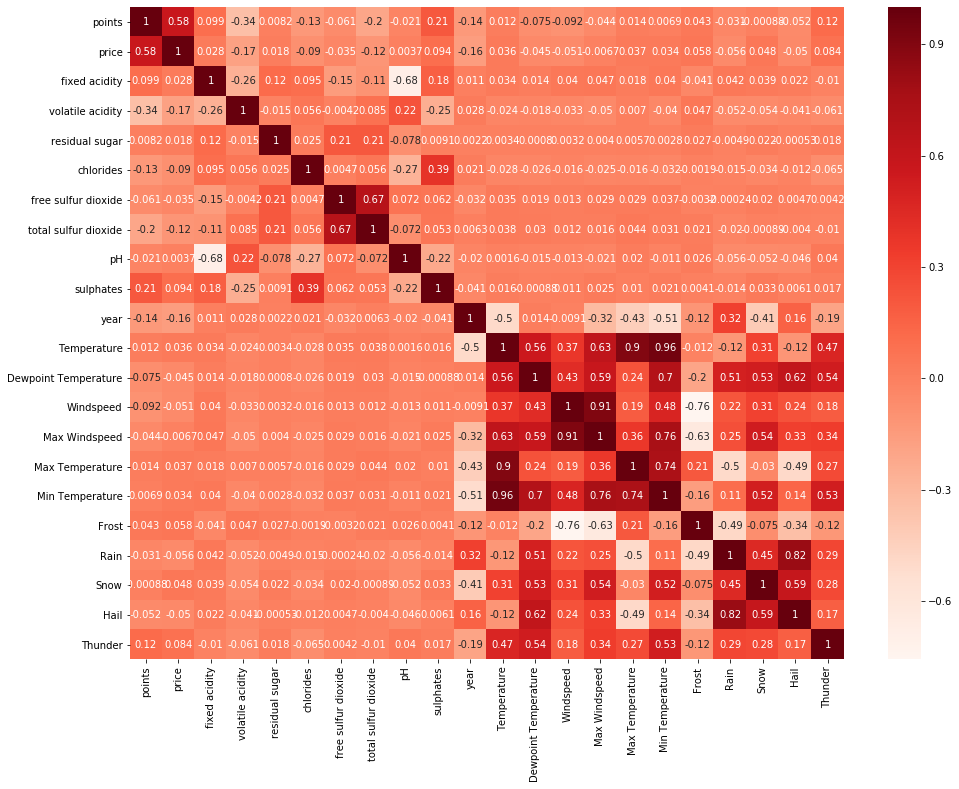

In [71]:
# Correlatie tabel voor dataset redwines
plt.figure(figsize=(16,12))
correlation_matrix = redwines_with_yeartemperatures.drop(['description','title','Tornado','count'],axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

Het is belangrijk om inzicht te hebben in hoe de punten zijn verdeeld. Na een korte analyse kwamen we erachter dat alle punten zijn verdeeld tussen 80 en 100. Daarmee is een wijn van 80 punten opeens de slechtst beoordeelde wijn terwijl het lijkt alsof dit een redelijk hoge score is. In onderstaande bar plot is te zien hoe de punten zijn verdeeld. 

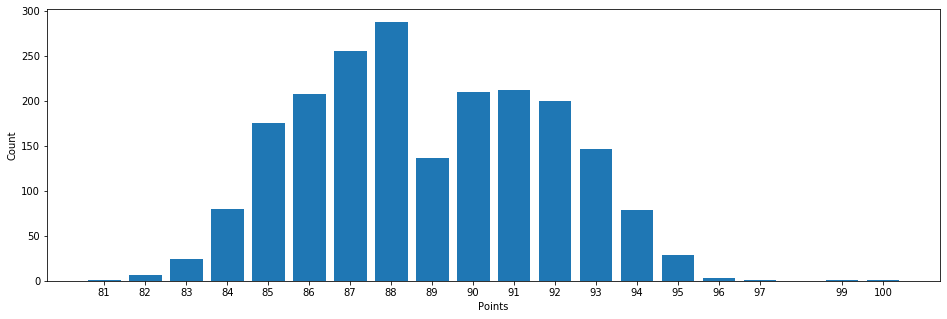

In [72]:
# Punt verdeling
points = redwines.groupby('points').sum()
plt.figure(figsize=(16,5))
plt.xticks(points.index)
plt.bar(points.index, points['count'])
plt.xlabel('Points')
plt.ylabel('Count')
plt.show()

Wij hebben ook besloten om een paar box plotten te maken van specifieke waarden om zo te zien hoe die zijn verdeeld.
Hier uit is te op te merken dat de pH relatief dicht bij elkaar ligt en dat er niet veel waarden zijn die er veel afwijken.

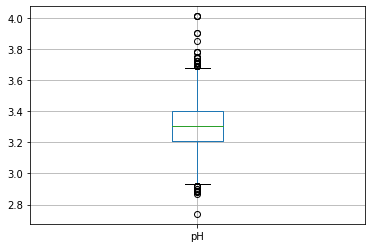

In [73]:
boxplot = redwines.boxplot('pH')

Hier uit is te zien dat het suiker gehalte veel waardes zijn die ver afwijken. Intresant genoeg zijn al deze waarden hoger dan de mediaan en zijn er weinig waarden lager

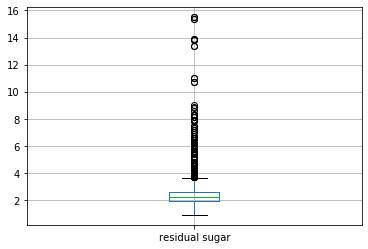

In [74]:
boxplot = redwines.boxplot('residual sugar')

We vroegen ons als groepje ook af wat de correlatie is tussen wijn prijs en gegeven punten. Je zou zeggen dat de duurdere wijnen ook beter beoordeeld moeten zijn. Het aantal punten zou dus moeten oplopen naarmate de prijs hoger wordt. Dit bleek ook enigzins het geval zoals in de onderstaande scatter plot te zien is. Het is soms ook lastig te zeggen aangezien het onderlinge verschil tussen gegeven punten niet erg hoog is. Er is per puntenaantal een gemiddeld van de prijs genomen, en dit gemiddelde wordt getoond per puntenaantal.

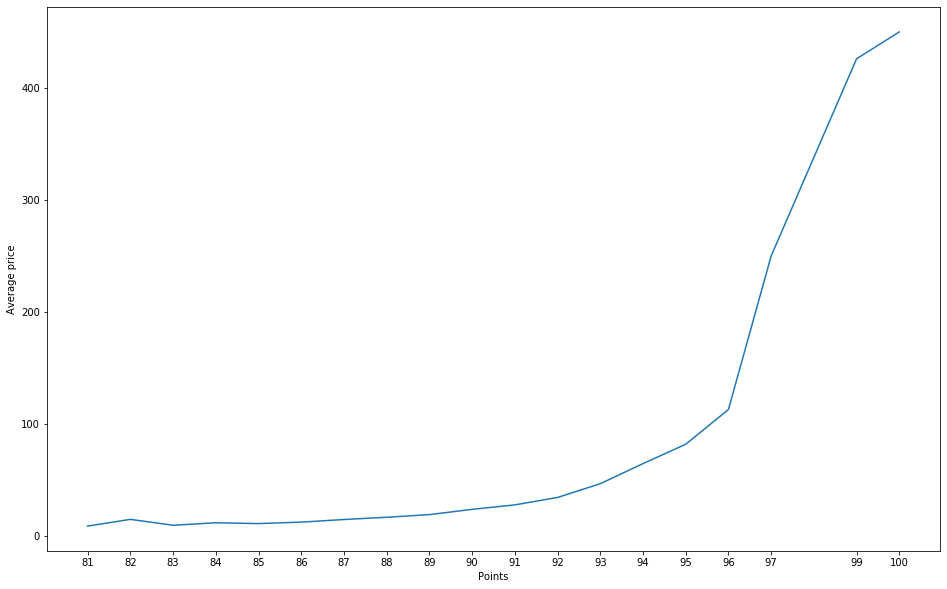

In [75]:
# Points in vergelijking met gemiddelde prijs 
avg = redwines.groupby('points').sum()
avg['avg_price_per_point'] = avg['price'] / avg['count']
plt.figure(figsize=(16,10))
plt.xticks(avg.index)
plt.plot(avg.index, avg['avg_price_per_point'])
plt.xlabel('Points')
plt.ylabel('Average price')
plt.show()

Ook dachten we dat er misschien een verband tussen goedkope wijn en veel suiker zou zijn, i.v.m. het feit dat suiker een goedkope grondstof is. Dit bleek echter minder uit te maken dan we eerst dachten. Er is geen overduidelijk verband te vinden tussen lagere wijnprijzen en hogere suikergehaltes zoals in de onderstaande scatter plot te zien is.

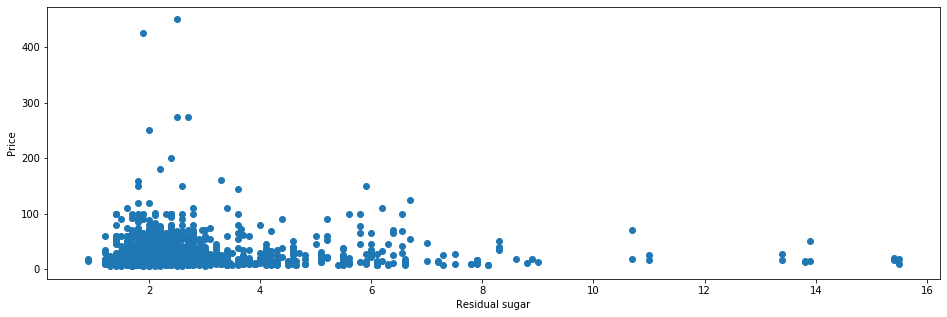

In [76]:
# suiker in verhouding to prijs 
plt.figure(figsize=(16,5))
plt.scatter(redwines['residual sugar'], redwines['price'])
plt.ylabel('Price')
plt.xlabel('Residual sugar')
plt.show()

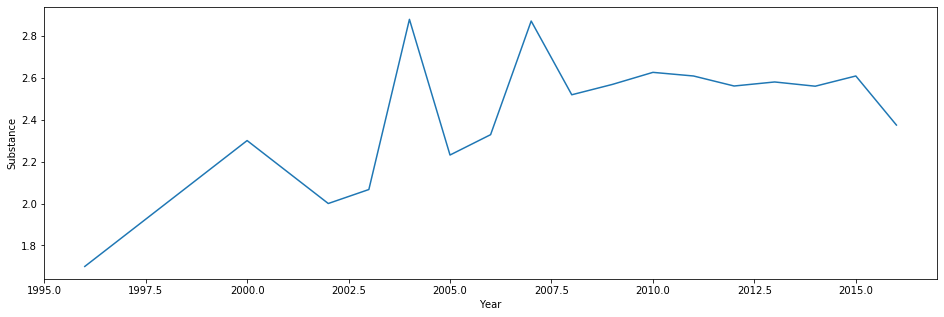

In [77]:
# verhoging van suikergehalte over de jaren
avg = redwines.groupby('year').sum()
avg['avg_increase_substance'] = avg['residual sugar'] / avg['count']
plt.figure(figsize=(16,5))
plt.plot(avg.index, avg['avg_increase_substance'])
plt.ylabel('Substance')
plt.xlabel('Year')
plt.show()

C:\Users\Freek\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Freek\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


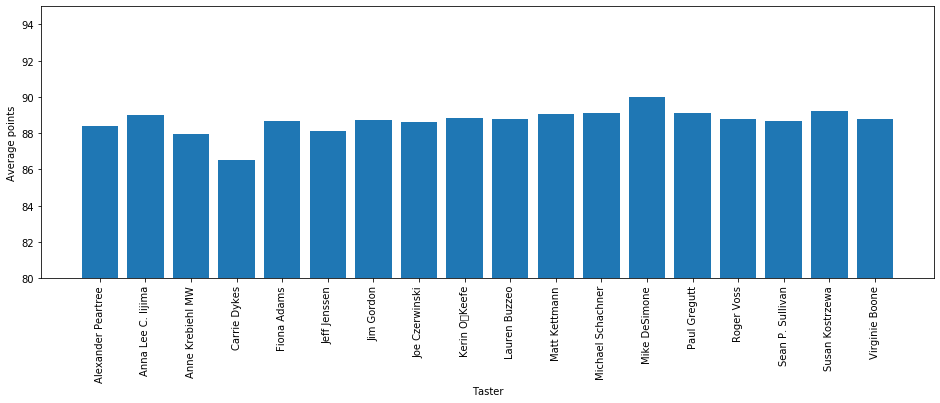

In [78]:
# Gemiddelde score per wijnproever
avg = redwines.groupby('taster_name').sum()
avg['avg_taster_given_points'] = avg['points'] / avg['count']
plt.figure(figsize=(16,5))
axes = plt.gca()
axes.set_ylim([80,95])
plt.bar(avg.index, avg['avg_taster_given_points'])
plt.ylabel('Average points')
plt.xlabel('Taster')
plt.xticks(avg.index, rotation='vertical')
plt.show()

Ook hebben wij gekeken naar de correlatie punten en jaar. Goed is wel om te vermelde dat er weinig wijnen uit het jaar 1996 kwamen. Dus die scoren is gebaseerd op een zeer kleine testgroep. 

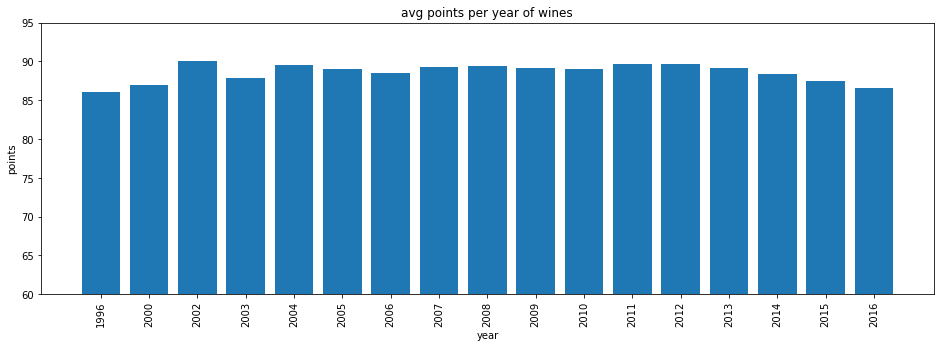

In [79]:
# Gemidddelde punten gegeven per jaar
avg_points_per_year = redwines.copy()
avg_points_per_year['year'] = avg_points_per_year['title'].str.extract(r"([1][9][9]\d|[2][0][0,1,2]\d)")
avg_points_per_year = avg_points_per_year[avg_points_per_year['year'].notnull()]
avg_points_per_year['count'] = 1
avg_points_per_year = avg_points_per_year.groupby('year').sum()
avg_points_per_year['avg_points_per_year'] = avg_points_per_year['points'] / avg_points_per_year['count']
plt.figure(figsize=(16,5))
axes = plt.gca()
axes.set_ylim([60,95])
plt.bar(avg_points_per_year.index, avg_points_per_year['avg_points_per_year'])
plt.xticks(avg_points_per_year.index, avg_points_per_year.index, rotation='vertical')
plt.title('avg points per year of wines')
plt.xlabel('year')
plt.ylabel('points')
plt.show()

__CREATING THE MODEL FOR CORRELATION BETWEEN POINTS AND AVERAGE YEARLY WEATHER CONDITIONS__

In [80]:
# Normaliseren van data
#x = redwines_with_yeartemperatures.drop(['description','title','designation','taster_name','province','winery'],axis=1).values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x)
#redwines_with_yeartemperatures = pd.DataFrame(x_scaled)

# ['Temperature', 'Dewpoint Temperature','Windspeed','Max Windspeed','Max Temperature','Min Temperature','Frost','Rain','Snow','Hail','Thunder']
# dependent and independent columns
dependent = redwines_with_yeartemperatures['points']
independent = redwines_with_yeartemperatures[['Temperature', 'Dewpoint Temperature','Windspeed','Max Windspeed','Max Temperature','Min Temperature','Frost','Rain','Snow','Hail','Thunder']]

# Test en train set
X_train, X_test, y_train, y_test = train_test_split(independent, dependent, random_state=0, test_size=0.05)

# Opzetten en trainen van model
model = LogisticRegression()
model.fit(X_train, y_train)

# Testen en uitrekenen nauwkeurigheid
#print(model.predict(X_test))
print(model.score(X_test,y_test))

# LinearRegression 8%
# DecisionTreeClassifier 12%
# LogisticRegression 15%
# BayesianRidge 6%
# SVR 5%
# DecisionTreeRegressor 7%
# Ridge 5%

0.1650485436893204


C:\Users\Freek\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Freek\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Uit dit model is gebleken dat LogisticRegression het best werkt. Met een nauwkeurigheid van 15% is dit het beste model tot nu toe.

__CREATING THE MODEL FOR CORRELATION BETWEEN POINTS AND CHEMICAL PROPERTIES__

In [81]:
# ['fixed acidity', 'volatile acidity','citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide','total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
# ["fixed acidity", "volatile acidity", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "pH", "sulphates"]
# Catogoriseren van data
dependent = redwines_with_yeartemperatures["points"]
#independent = redwines_with_yeartemperatures[["fixed acidity", "volatile acidity", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "pH", "sulphates"]]
independent = redwines_with_yeartemperatures[["volatile acidity","total sulfur dioxide"]]

# Test en train set
X_train, X_test, y_train, y_test = train_test_split(independent, dependent, random_state=0, test_size=0.2)

# Opzetten en trainen van model
model = LogisticRegression()
model.fit(X_train, y_train)

# Testen en uitrekenen van nauwkeurigheid
#print(model.predict([[13,25]]))
print(model.score(X_test,y_test))

# LinearRegression 8%
# DecisionTreeClassifier 12%
# LogisticRegression 15%
# BayesianRidge 6%
# SVR 5%
# DecisionTreeRegressor 7%
# Ridge 5%

0.16262135922330098


C:\Users\Freek\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Freek\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Ook hieruit blijkt dat LogisticRegression het beste model is voor het voorspellen. Er zit bijna geen verschil in uitkomst t.o.v. het vorige model.

## Onderzoek vraag 3
#### Correlatie tussen chemische eigenschappen en score

Wij willen graag weten of de de score van een protugeese red te vorspellen is gegeven de chemische eigenschappen. Mocht dit namelijk zo zijn dan kunnen wij mischien ook in een later stadium achterhalen welke chemische eigenschappen en in welke hoeveelheid zorgen voor een hogere score. Dit is zeer belangrijke informatie die alle wijnbrouwerijen graag willen hebben.

Allereest zullen wij kijken of de .corr functie die inszicht probeerd te geven in de correlatie tussen eigenschappen.
Een correlatie kan vinden tussen de score en een andere eigenschap van de wijn

In [82]:
redwines.corr()['points']

points                  1.000000
price                   0.579681
fixed acidity           0.098916
volatile acidity       -0.341979
residual sugar          0.008177
chlorides              -0.128953
free sulfur dioxide    -0.060824
total sulfur dioxide   -0.202779
pH                     -0.021254
sulphates               0.209667
year                   -0.139069
count                        NaN
Name: points, dtype: float64

Dit geeft geen goed vooruitzicht. Volgens de functie schijn er zeer weinig correlatie te zijn tussen de chemische eigenschappen en de score. Een conclusie dat er geen correlatie is lijk tot dusver het logischt.

Wij zullen dit veder uitzoeken met behulp van algortime. 

Allereerst maken wij een baseline. Een baseline is de simpleste oplossing voor een probleem en kijken welk resultaat die oplevert. Dit is handig omdat je zo kan zien hoe goed je algortime daatwerkelijk scoort. ZO kan je inuatief denken dat 80% accuracy een goede score is maar kan je bijvoorbeeld met willekeurig een getal kiezen op een accuracy van 78% uikomen. Dan heeft je algortime dus niet veel toegevoegde waarden. 

Voor onze baseline is gekozen om een continue de scoren 88 te voorspellen. Dit is namelijk het meest voorkomende getal(de modus).

In [83]:
modus_pred = pd.Series(88, index=[redwines.index])
accuracy_score(redwines['points'], modus_pred)

0.13980582524271845

De baseline heeft een score van circa 14%. Nu zullen wij een liniare regressie model proberen te bouwen.

Allereeste moeten we zorgen dat liniare regressie kan worden uitgevoerd op de data set. Hiervoor moeten we dus alle strings wegehalen) en vervange door andere waarden.

In [84]:
redwines.dtypes

description              object
designation              object
points                    int64
price                   float64
province                 object
taster_name              object
title                    object
winery                   object
fixed acidity           float64
volatile acidity        float64
citric acid              object
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                  object
pH                      float64
sulphates               float64
alcohol                  object
year                      int32
count                     int64
dtype: object

In de bovenstaande tabel is te zien dat de kolom 'density', 'citric acid' en 'alcohol' niet de juiste datatypen hebben. We willen hier floats hebben terwijl ze nu aangegeven worden als Strings. Om dit op te lossen gaan we over de kolommen heen en zetten iedere String om tot een float. Wanneer dit niet kan omdat de waarde dit niet toelaat wordt er een NaN ingevuld.

In [85]:
redwines['citric acid'] = pd.to_numeric(redwines['citric acid'], errors='coerce')
redwines['density'] = pd.to_numeric(redwines['density'], errors='coerce')
redwines['alcohol'] = pd.to_numeric(redwines['alcohol'], errors='coerce')

pd.isnull(redwines).sum()

description               0
designation               0
points                    0
price                     0
province                  0
taster_name               0
title                     0
winery                    0
fixed acidity             0
volatile acidity          0
citric acid             172
residual sugar            0
chlorides                 0
free sulfur dioxide       0
total sulfur dioxide      0
density                   1
pH                        0
sulphates                 0
alcohol                  10
year                      0
count                     0
dtype: int64

Hieruit blijk dat er circa 180 waarden zijn die niet naar een float kunnen worden gecovoteerd. Wij hebben besloten om deze waarden uit onze data te halen. Ze kunnen ook geimpleerd worden maar aangezien wij de correlatie tussen deze waarden en de scoren willen vergelijken moet onze data wel exact zijn en wij kunnen niet garanderen dat als er een correlatie zit die ook mee wordt genomen in het interpoleren.

In [86]:
redwines_strings_dropped = redwines.copy()
redwines_strings_dropped.dropna(inplace=True)

In [87]:
# Creeër het lineare regressie object vanuit de module sklearn
red_wine_linreg_model = LinearRegression()

# Selecteren van kenmerken en doel
X = redwines_strings_dropped.loc[:,'fixed acidity':]
y = redwines_strings_dropped['points']

# Verdelen van data in train en testdata
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print("Aantal waarden in de training set: {0}".format(len(X_train)))
print("Aantal waardes in de test set: {0}".format(len(X_test)))

# Start leerproces
red_wine_linreg_model.fit(X_train, y_train)

Aantal waarden in de training set: 1407
Aantal waardes in de test set: 470


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Na het maken van het model, willen we graag weten welke coëficiënt het model heeft gekregen. Hieruit is namelijk op te maken hoe hoog het model de correlatie tussen bepaalde waarden inschat.

In [88]:
pd.DataFrame({'features': X.columns, 'coefficients': red_wine_linreg_model.coef_})

,features,coefficients
0,fixed acidity,-0.077335
1,volatile acidity,-3.102398
2,citric acid,-0.023480
3,residual sugar,-0.023401
4,chlorides,-5.682664
5,free sulfur dioxide,0.005279
6,total sulfur dioxide,-0.010270
7,density,0.009271
8,pH,-1.765934
9,sulphates,1.944891


We zien we dat chorides veel invloed heeft. Ook hebben volatile acicity, sulphates en alcohol invloed op de lijn.
Om te bepalen hoe of de voorspellende waarde overeenkomen met de werkelekheid. Laen we het algoritme voorspellingen laten met behulp van de test set.

In [89]:
features = ["fixed acidity","volatile acidity","citric acid","residual sugar",
            "chlorides","free sulfur dioxide ","total sulfur dioxide","pH","sulphates","alcohol"]


        
def make_line_model(target,features_list):
    selected_features_regr_model = LinearRegression()
    X = redwines_strings_dropped[features_list]
    y = redwines_strings_dropped[target]

    # Creeëren van een train en test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    # Start leerproces
    selected_features_regr_model.fit(X_train, y_train)

    # Het maken van voorspellingen d.m.v. de testset
    wine_regr_test_orig = selected_features_regr_model.predict(X_test)
    wine_regr_test_rounded = np.rint(np.floor(selected_features_regr_model.predict(X_test)))

    # Uitrekenen van de gemiddelde afwijking
    avg_dev = abs(wine_regr_test_orig - y_test).sum() / len(y_test)

    # Uitrekenen van de root mean squared error
    print("LinearRegression model with the features: {0}".format(features_list) )
    print("Algemene score (met afronding): {0}".format(accuracy_score(wine_regr_test_rounded, y_test)))
    print("\nGemiddelde afwijking: {0}".format(avg_dev))
    print("\n")

make_line_model('points',["fixed acidity","volatile acidity","citric acid","residual sugar",
            "chlorides","free sulfur dioxide","total sulfur dioxide","pH","sulphates","alcohol"])
make_line_model('points',["chlorides","pH","sulphates","alcohol"])
make_line_model('points',["chlorides"])
make_line_model('points',["pH"])
make_line_model('points',["sulphates"])
make_line_model('points',["alcohol"])

LinearRegression model with the features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']
Algemene score (met afronding): 0.19148936170212766

Gemiddelde afwijking: 1.9807677905633658


LinearRegression model with the features: ['chlorides', 'pH', 'sulphates', 'alcohol']
Algemene score (met afronding): 0.1723404255319149

Gemiddelde afwijking: 2.06749176715754


LinearRegression model with the features: ['chlorides']
Algemene score (met afronding): 0.125531914893617

Gemiddelde afwijking: 2.5440964606180967


LinearRegression model with the features: ['pH']
Algemene score (met afronding): 0.1127659574468085

Gemiddelde afwijking: 2.582427252201153


LinearRegression model with the features: ['sulphates']
Algemene score (met afronding): 0.1276595744680851

Gemiddelde afwijking: 2.4909813523516107


LinearRegression model with the features: ['alcohol']
Algemene score (met afro

De resulaten zijn dusdaning laag dat er geen correlatie is te vinden tussen de eigenschappen en de score. Een verklaring hiervoor is dat er wel een correlatie is maar dat het algoritme moeite heeft een preciese score te berkenen. ZO kan bijvoorbeeld meer sulfide wel gelijk staan aan een hogere score maar voorspelt het algoritme 90 in plaats van 91 dus word het als fout gerekend. Een oplossing hievoor is om de punten in groepen te verdelen wij hebben in eerste instantie gekozen om ze in groepen van 2 optedelen.




In [90]:
def organize_prize_groups(group_size):
    # Wanneer je de laagste waaarde van de huidige waarde haalt heb je het verschil. 
    # Daarbij zie je dat alle groepen consistent stijgen.
    # Je kan het nummber verdelen door de toename om een groep te krijgen.
    # Voeg 1 toe om de groep te laten starten bij 1 en niet 0
    
    #if you substract the lowest value from the current value you get the differnce. 
    #Seeing as all the groups have a consistent increasement
    #you can devide the number by the increasement to get the group 
    #Add to make the groups start at 1 and not 0
    
    redwines_strings_dropped["Points group"] = round((redwines_strings_dropped["points"] - 81) / group_size + 1)


In [91]:
organize_prize_groups(3)
redwines_strings_dropped

,description,designation,points,price,province,taster_name,title,winery,fixed acidity,volatile acidity,...,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,year,count,Points group
0,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Kerin OKeefe,Quinta dos Avidagos 2011 Avidagos Red (Douro),Quinta dos Avidagos,10.0,0.290,...,0.098,10.0,26.0,10.00600,3.48,0.91,9.7,2011,1,3.0
1,"From an estate in the south of the Alentejo, t...",Grande Reserva Tinto,91,26.0,Alentejano,Roger Voss,Casa Santa Vitória 2013 Grande Reserva Tinto R...,Casa Santa Vitória,8.3,0.260,...,0.076,8.0,23.0,0.99740,3.26,0.70,9.6,2013,1,4.0
2,A year in wood and 30 months in bottle before ...,Montes Claros Garrafeira,90,28.0,Alentejo,Paul Gregutt,Adega Cooperativa de Borba 2012 Montes Claros ...,Adega Cooperativa de Borba,7.0,0.690,...,0.091,15.0,21.0,0.99572,3.38,0.60,11.3,2012,1,4.0
4,"A powerful wine, richly structured and full of...",Gerações Colheita Seleccionada,92,34.0,Alentejano,Paul Gregutt,Herdade Grande 2010 Gerações Colheita Seleccio...,Herdade Grande,8.0,0.480,...,0.073,16.0,25.0,0.99360,3.28,0.66,12.4,2010,1,5.0
5,This is a new wine from the hands of master wi...,Monte de Carrapatelo Colheita Seleccionada Tinto,92,30.0,Alentejano,Michael Schachner,Luis Duarte 2013 Monte de Carrapatelo Colheita...,Luis Duarte,8.2,0.230,...,0.069,9.0,17.0,0.99376,3.21,0.54,12.3,2013,1,5.0
6,As its name suggests this is a selection of ba...,Lagoalva Barrel Selection Tinto,92,23.0,Tejo,Kerin OKeefe,Quinta da Lagoalva de Cima 2013 Lagoalva Barre...,Quinta da Lagoalva de Cima,10.8,0.470,...,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,2013,1,5.0
8,"Powerful and concentrated, this is just at its...",Grande Reserva,92,32.0,Alentejo,Anna Lee C. Iijima,Monte da Penha 2005 Grande Reserva Red (Alentejo),Monte da Penha,7.9,0.330,...,0.056,6.0,35.0,0.99396,3.29,0.71,11.0,2005,1,5.0
9,"This mature wine has a soft, smooth character ...",VT '08,90,32.0,Douro,Roger Voss,Quinta do Sagrado 2008 VT '08 Red (Douro),Quinta do Sagrado,7.0,0.690,...,0.091,15.0,21.0,0.99572,3.38,0.60,11.3,2008,1,4.0
10,"A ripe and structured wine, this has bold blac...",Aneto Tinto,90,12.0,Douro,Virginie Boone,Sobredos 2012 Aneto Tinto Red (Douro),Sobredos,8.8,0.270,...,0.095,20.0,29.0,0.99488,3.26,0.56,11.3,2012,1,4.0
12,Just lightly touched by wood this is a bright ...,Evel Tinto,87,13.0,Douro,Virginie Boone,Real Companhia Velha 2014 Evel Tinto Red (Douro),Real Companhia Velha,9.3,0.270,...,0.091,6.0,16.0,0.99800,3.28,0.70,9.7,2014,1,3.0


In [92]:
make_line_model('Points group',["sulphates"])
make_line_model('Points group',["alcohol"])
make_line_model('Points group',["fixed acidity","volatile acidity","citric acid","residual sugar",
            "chlorides","free sulfur dioxide","total sulfur dioxide","pH","sulphates","alcohol"])

modus_pred = pd.Series(3, index=[redwines_strings_dropped.index])
accuracy_score(redwines_strings_dropped['Points group'], modus_pred)


LinearRegression model with the features: ['sulphates']
Algemene score (met afronding): 0.3382978723404255

Gemiddelde afwijking: 0.8596784019682537


LinearRegression model with the features: ['alcohol']
Algemene score (met afronding): 0.4085106382978723

Gemiddelde afwijking: 0.7027803820954734


LinearRegression model with the features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']
Algemene score (met afronding): 0.3404255319148936

Gemiddelde afwijking: 0.6678516668238551




0.36547682472029835

Hieruit blijkt dus dat ook als je het in groepen verdeeld en het algortime niet meer de exacte score hoeft te weten maar alleen ongeveer de score te kunnen bepalen. Dat het nog steeds geen correlatie vind tussen de chemische eigenschappen en de score. Wij kunnen dus concluderen dat er door middel van liniare regressie geen score te vinden valt.

In [93]:
# Creeër de decision tree object
wine_decision_tree = DecisionTreeClassifier(max_depth=200)

# Selecteer de kenmerken en het doel
X = redwines_strings_dropped.loc[:,'fixed acidity':]
y = redwines_strings_dropped['points']

# Split de dataset op in een train en test set
X_train, X_analysis, y_train, y_analysis = train_test_split(X, y, random_state=0)

# Creeëren van een train en test set
X_validate, X_test, y_validate, y_test = train_test_split(X_analysis, y_analysis, random_state=0, test_size=0.5)

# Fit de data
wine_decision_tree.fit(X_train, y_train)

# Validatie nauwkeurigheid score
val_score = wine_decision_tree.score(X_validate, y_validate)

# Test nauwkeurigheid score
test_score = wine_decision_tree.score(X_test, y_test)

print(str(val_score) + " " + str(test_score))
    



0.574468085106383 0.5617021276595745


Hieruit komt een zeer hoge score naar boven. Maar deze boom waarschijnlijk erg overfit. Als we een maximum diepte bepalen dan komt er het volgende uit.

In [94]:
def tune_decision_tree(depth):
    # Creeër de decision tree object
    wine_decision_tree = DecisionTreeClassifier(max_depth=depth)

    # Selecteer de kenmerken en het doel
    X = redwines_strings_dropped.loc[:,'fixed acidity':]
    y = redwines_strings_dropped['points']

    # Split de dataset op in een train en test setf
    X_train, X_analysis, y_train, y_analysis = train_test_split(X, y, random_state=0)

    # Creeëren van een train en test set
    X_validate, X_test, y_validate, y_test = train_test_split(X_analysis, y_analysis, random_state=0, test_size=0.5)

    # Fit de data
    wine_decision_tree.fit(X_train, y_train)

    # Validatie nauwkeurigheid score
    val_score = wine_decision_tree.score(X_validate, y_validate)
    
    # Test nauwkeurigheid score
    test_score = wine_decision_tree.score(X_test, y_test)
    
    return (val_score, test_score)

for x in range(1, 13):
    tree_result = tune_decision_tree(x)
    print("n: {0}; accuracy validation: {1}; accuracy test: {2}".format(x, tree_result[0], tree_result[1]))



n: 1; accuracy validation: 0.2553191489361702; accuracy test: 0.22127659574468084
n: 2; accuracy validation: 0.425531914893617; accuracy test: 0.39574468085106385
n: 3; accuracy validation: 0.4808510638297872; accuracy test: 0.5404255319148936
n: 4; accuracy validation: 0.723404255319149; accuracy test: 0.6851063829787234
n: 5; accuracy validation: 0.7276595744680852; accuracy test: 0.676595744680851
n: 6; accuracy validation: 0.7021276595744681; accuracy test: 0.6851063829787234
n: 7; accuracy validation: 0.6553191489361702; accuracy test: 0.6468085106382979
n: 8; accuracy validation: 0.6638297872340425; accuracy test: 0.6212765957446809
n: 9; accuracy validation: 0.6340425531914894; accuracy test: 0.6
n: 10; accuracy validation: 0.6297872340425532; accuracy test: 0.5829787234042553
n: 11; accuracy validation: 0.625531914893617; accuracy test: 0.5787234042553191
n: 12; accuracy validation: 0.5914893617021276; accuracy test: 0.5787234042553191


## 4. Kan je op basis van score en prijs achterhalen in welke regio de wijn zijn oorsprong heeft.
Voor deze onderzoeksvraag is de data onderzocht per maand. Om deze vraag te beantwoorden, kijk ik eerst naar correlaties tussen de data van de maanden. Deze zijn gepresenteerd hieronder in een heatmap.

In [95]:
# Het omzetten van alle data gegroepeert op maand
redwines['count'] = 1
avg_per_province = redwines.groupby('province').sum() 
avg_per_province.loc[:, "points":"sulphates"] = avg_per_province.loc[:, "points":"sulphates"].div(avg_per_province['count'], axis=0)
avg_per_province['province'] = avg_per_province.index

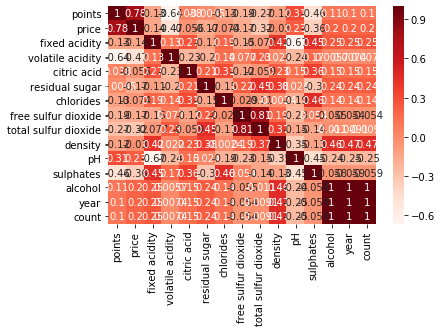

In [96]:
# Correlatieschema van alle gemiddeldes van alle maanden
correlation = avg_per_province.corr()
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)

tussen price en points zit een aardige correlatie. Wat betekent dat per regio de verhouding van punten gegeven door wijnproevers en de prijs aardig hoog ligt. Ook is de total sulfur dioxide ten opzichte van de sulfur vrije dioxide een aardige correlatie te vinden.

Ik wil nu verder met de correlatie tussen price en points.

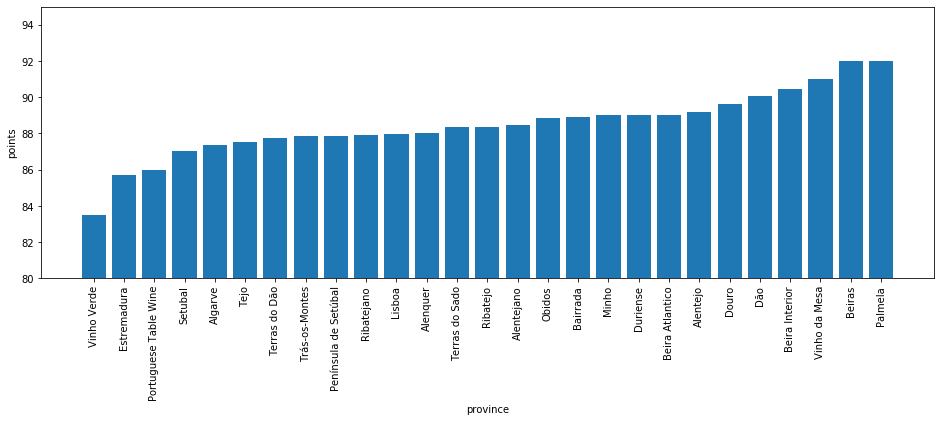

In [97]:
# Gemiddelde punten per regio
avg_points_sorted = avg_per_province.sort_values(by=['points'])
plt.figure(figsize=(16,5))
plt.xticks(np.arange(27),(avg_points_sorted.index), rotation='vertical')
plt.ylim(80, 95)
plt.bar(avg_points_sorted['province'], avg_points_sorted['points'])
plt.xlabel('province')
plt.ylabel('points')
plt.show()

het gemiddelde aantal punten per regio liggen niet ver van elkaar af. Op basis van alleen punten zullen we dus niet kunnen concluderen welke regio de wijn vandaan komt.

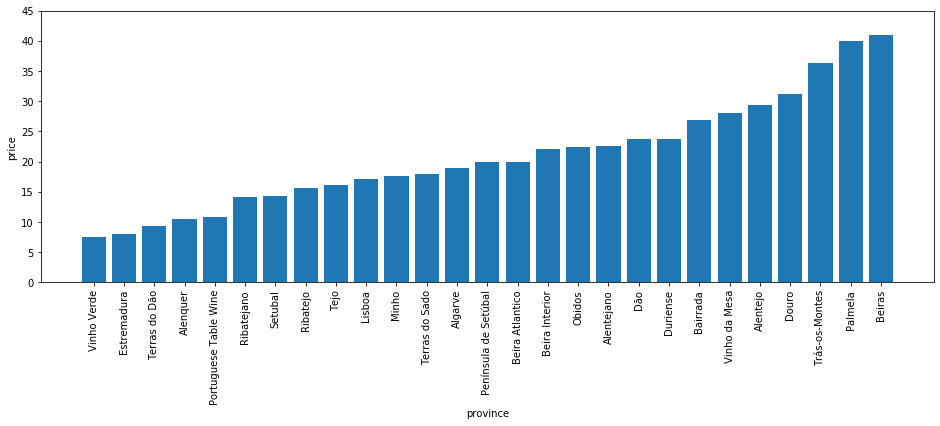

In [98]:
# Gemiddelde prijs per regio
avg_points_sorted = avg_per_province.sort_values(by=['price'])
plt.figure(figsize=(16,5))
plt.xticks(np.arange(27),(avg_points_sorted.index), rotation='vertical')
plt.ylim(0, 45)
plt.bar(avg_points_sorted['province'], avg_points_sorted['price'])
plt.xlabel('province')
plt.ylabel('price')
plt.show()

Uit de grafiek blijkt dat er best veel verschil zit tussen de gemiddelde prijs per provincie. Op basis van deze informatie ik een model bouwen welke a.d.h.v. prijs en score welke probeert te achterhalen waar de wijn vandaan komt.

Op het moment ben ik benieuwd of er een duidelijk verband is tussen de prijs en punten per maand. Hiervoor brengt ik de vorige twee grafieken in kaart in een grafiek gecategoriseerd op maand.

In [99]:
# Namen geven aan een variabel
avg_price = avg_per_province['price']
avg_points = avg_per_province['points']
index = avg_per_province.index

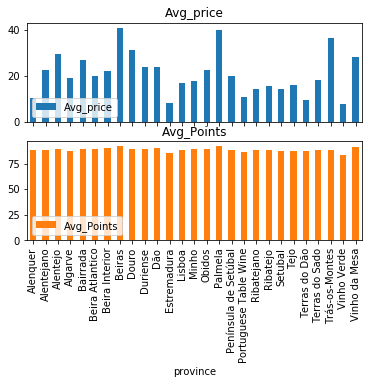

In [100]:
# Grafiek van gemiddelde prijs en punten per provincie
df = pd.DataFrame({'Avg_price': avg_price,
                   'Avg_Points': avg_points}, index = index)
axes = df.plot.bar(rot=90, subplots=True)
axes[0].legend(loc=3)
axes[1].legend(loc=3)

Ondanks de hogere correlatie (0,78) bij de heatmap tussen score en prijs gecategoriseerd per maand, zie ik niet heel veel bijzonders aan de grafiek hierboven. Een ding wat je wel kan waarnemen dat enkele provincies met gemiddeld hogere wijnprijzen een iets hogere gemiddelde score heeft. Zo ook met gemiddelde lage wijnprijzen en scores. Echter blijft dat een kleine ontdekking.

Toch wil ik een model in elkaar zetten wat een voorspelling doet op basis van de hoofdvraag.

In [101]:
# Omzetten van maand in een integer
month = {}
counter = 1
for item in avg_per_province.index:
    month[str(item)] = counter
    counter+=1
redwines['province'] = [month[str(item)] for item in redwines['province']]

In [102]:
# Variables een naam geven
dependent = redwines['province']
independent = redwines[['points', 'price']]

# Een gemiddelde percentage als uitkomst nemen uit een x aantal testen
scores_in_percentage = []    
random_seed = 0
testen = 10
for i in range(testen):
    
    # Test en train set
    X_train, X_test, y_train, y_test = train_test_split(independent, dependent, random_state=random_seed, test_size=0.2)
    random_seed+=1
    
    # Training model
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    
    # Voeg de score toe aan lijst met gevonden scores
    scores_in_percentage.append(model.score(X_test, y_test))

# Rekent het gemiddelde uit van alle percentuele scores    
print(abs(((sum(scores_in_percentage)) / (len(scores_in_percentage))) * 100))

32.66990291262136


Wat op viel was dat er 3 modellen aardig goed presteerden. De DecisionTreeClassifier functie aan top met een nauwkeurigheid van 33,3%. De functie logisticRegression had een nauwkeurigheid van 32,0% en DecisionTreeRegressor kwam met 14,5% nauwkeurigheid. Alle test zijn gedaan op basis van 10 testen en daarvan het gemiddelde.

Uit deze informatie blijkt dat er aan de hand van deze dataset geen goede voorspelling kan worden gedaan waar de wijn vandaan komt.

Hierna keek ik of er op basis van andere elementen een goede voorspelling kan worden gedaan. Ik heb nog maals enkele test gedaan met meer parameters.

In [103]:
# Variables een naam geven
dependent = redwines['province']
independent = redwines[['total sulfur dioxide', 'price', 'points']]

# Een gemiddelde percentage als uitkomst nemen uit een x aantal testen
scores_in_percentage = []    
random_seed = 0
testen = 100
for i in range(testen):
    
    # Test en train set
    X_train, X_test, y_train, y_test = train_test_split(independent, dependent, random_state=random_seed, test_size=0.2)
    random_seed+=1
    
    # Training model
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    
    # Voeg de score toe aan lijst met gevonden scores
    scores_in_percentage.append(model.score(X_test, y_test))
    

# Rekent het gemiddelde uit van alle percentuele scores    
print(abs(((sum(scores_in_percentage)) / (len(scores_in_percentage))) * 100))

100.23111380404852


Met de functie DecisionTreeRegressor kan er tot 82,9 % nauwkeurigheid worden voorspelt welke regio er bij de wijn hoort op basis van totaal zwaveldioxide, prijs en punten.

Nu ben ik erg benieuwd of het model veel kan halen uit een stuk of 8 willekeurige colums.

In [104]:
# Variables een naam geven
dependent = redwines['province']
independent = redwines[['points', 'price', 'fixed acidity', 'volatile acidity','residual sugar', 'total sulfur dioxide', 'chlorides']]

# Een gemiddelde percentage als uitkomst nemen uit een x aantal testen
scores_in_percentage = []    
random_seed = 0
testen = 10
for i in range(testen):
    
    # Test en train set
    X_train, X_test, y_train, y_test = train_test_split(independent, dependent, random_state=random_seed, test_size=0.2)
    random_seed+=1
    
    # Training model
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    
    # Voeg de score toe aan lijst met gevonden scores
    scores_in_percentage.append(model.score(X_test, y_test))

# Rekent het gemiddelde uit van alle percentuele scores    
print(abs(((sum(scores_in_percentage)) / (len(scores_in_percentage))) * 100))

99.22760715103799


Door vorige trainingssessies van modellen is er te zien dat de functie DecisionTreeRegressor vaak het beste uit de test komt. Door het combineren van de punten points, price, fixed acidity, volatile acidity, residual sugar, total sulfur dioxide, chlorides, kan er met 92,4% nauwkeurigheid gegokt worden waar de wijn vandaan komt.

Mijn conclusie is dat er op basis van punten en scores geen voorspelling kan worden gemaakt waar de wijn vandaan komt, dat komt voornamelijk doordat points voor de wijn te dicht op elkaar ligt. Echter wanneer er meer parameters worden meegenomen, is er met 92,4% zekerheid te zeggen waar de wijn vandaan komt.

## Hypothese toets

In [105]:
ph_sample = np.array([3.41, 3.51, 3.39, 3.11, 3.21, 3.50, 3.46, 3.37, 3.71]) # steekproef data

__Nul Hypothese (H0):__

_Er is geen significant verschil te vinden tussen de gemiddelde PH waardes van de steekproef en de populatie. Dat wil zeggen, als de z score aan de boven en onderkant binnen -1.960 en 1.960 (2,5% links en rechts, 95% in het midden) valt, is er geen significant verschil te vinden_

_Als de P waarde hoger is dan de alpha waarde, is er ook geen significant verschil._

__Alternatieve Hypothese (HA):__

_Er is wel een significant verschil tussen gemiddelde PH waardes van de steekproef en de populatie. Dat wil zeggen, als de z score aan de boven of onderkant buiten -1.960 en 1.960 (2,5% links en rechts, 95% in het midden) valt, is er wel een significant verschil te vinden_

_Als de P waarde lager is dan de alpha waarde, is er ook een significant verschil._

__Toetszijde(s):__

_Het gaat om tweezijdig (beide zijdes) toetsen, aangezien we een significant verschil zoeken, een verschil kan zowel aan de lage kant als aan de hoge kant zitten._

In [106]:
# Eerst de steekproef- en populatiestatistieken berekenen

# steekproefstatistieken
x_ = ph_sample.mean() # Gemiddelde van de steekproef
n = len(ph_sample) # Grootte steekproef
s = ph_sample.std()

# populatiestatistieken
population = len(redwines_with_yeartemperatures['pH'])
sigma = redwines_with_yeartemperatures['pH'].std() # Standaard deviatie van de populatie
mu = redwines_with_yeartemperatures['pH'].mean() # Gemiddlede van de populatie

# margin of error en standard error
alpha = 0.05 # 95% betrouwbaarheid
se = sigma / np.sqrt(n) # standard error using sigma of population, since its available

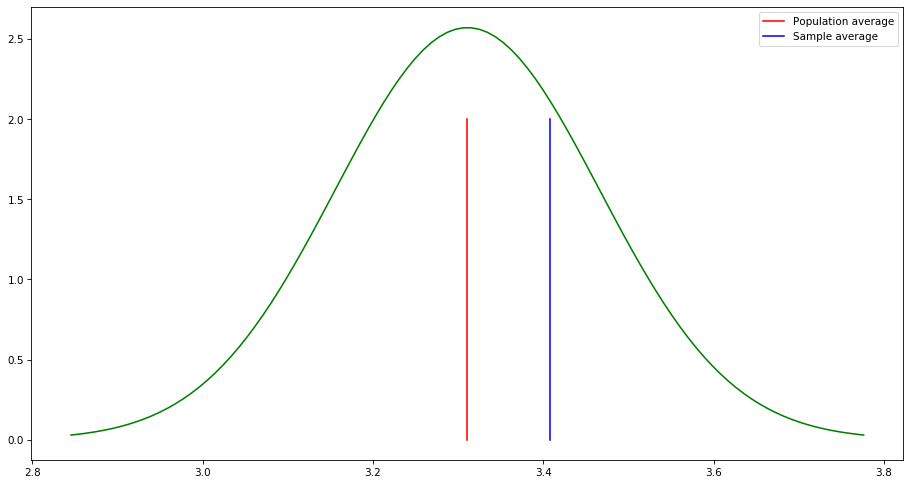

In [107]:
# plot de normaalverdeling met gemiddelde van populatie en gemiddelde van steekproef
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.figure(figsize=(15,8), dpi=75)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='green')
plt.plot([mu,mu],[0,2],color='red', label='Population average') # gemiddelde populatie
plt.plot([x_,x_],[0,2],color='blue', label='Sample average') # gemiddelde steekproef
plt.legend()
plt.show()

In [108]:
print("Methode 1:\n")

sample_z_score = (x_ - mu) / se
sample_alpha = stats.norm.pdf(sample_z_score)

print("Steekproef:")
print("Z Score Steekproef:\n", sample_z_score)
print("P waarde steekproef:\n", sample_alpha)

population_z_score = stats.norm.ppf((1 - alpha / 2)) # 2 zijdig 0.975

print("\nPopulatie:")
print("Z Score middelste 95% populatie (2,5 links en rechts):\n", population_z_score)
print("Margin of error populatie:\n", alpha)

print("\nSteekproef kans is hoger dan alpha populatie, dus verwerp HA : ~0.06 > 0.05")

Methode 1:

Steekproef:
Z Score Steekproef:
 1.8743091579469984
P waarde steekproef:
 0.06887541797074803

Populatie:
Z Score middelste 95% populatie (2,5 links en rechts):
 1.959963984540054
Margin of error populatie:
 0.05

Steekproef kans is hoger dan alpha populatie, dus verwerp HA : ~0.06 > 0.05


NameError: name 'grens_ph_sample_left' is not defined

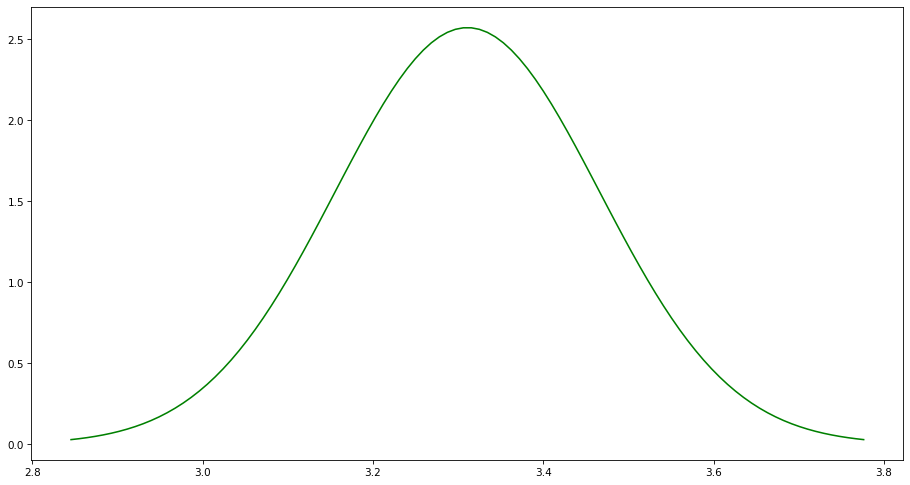

In [109]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.figure(figsize=(15,8), dpi=75)
plt.plot(x, stats.norm.pdf(x, mu, sigma),color='green')
plt.plot([grens_ph_sample_left,grens_ph_sample_left],[0,2],color='blue', label='Sample')
plt.plot([grens_ph_sample_right,grens_ph_sample_right],[0,2],color='blue')
plt.plot([grens_ph_population_left,grens_ph_population_left],[0,2],color='red', label='95% of Population')
plt.plot([grens_ph_population_right,grens_ph_population_right],[0,2],color='red')
plt.legend()
plt.show()

## Een interactieve visualisatie